In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

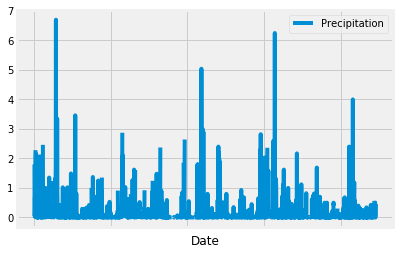

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
maxdate = session.query(func.max(Measurement.date)).scalar()
# Calculate the date 1 year ago from the last data point in the database
startdate = (dt.datetime.strptime(maxdate, '%Y-%m-%d') - relativedelta(years=1)).date()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.station,Measurement.date,Measurement.prcp,Measurement.tobs).filter(Measurement.date >= startdate).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df_prec = pd.DataFrame(results[:], columns=['Station','Date','Precipitation','Tobs'], index=session.query(Measurement.date).filter(Measurement.date >= startdate).all())
# Sort the dataframe by date
df_prec.sort_values(by='Date')
# Use Pandas Plotting with Matplotlib to plot the data
df_prec.sort_values(by='Date').plot(x='Date',y='Precipitation')

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(df_prec['Precipitation'].describe())

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).scalar()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
act_sta_id = session.query(Measurement.station,func.count(Measurement.date)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.date).desc()).first()[0]

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == act_sta_id).all()


[(54.0, 85.0, 71.66378066378067)]

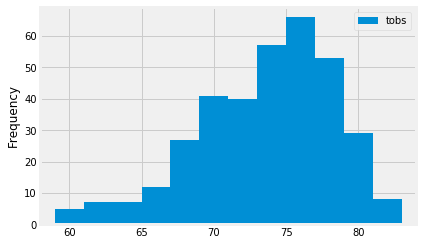

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act_temps = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.station == act_sta_id).filter(Measurement.date >= startdate).all())
#act_temps.ravel()
act_temps.plot.hist(bins=12,xlim=(58,84))

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
t = calc_temps('2011-02-28', '2011-03-05')
print(t)

[(61.0, 69.75510204081633, 75.0)]


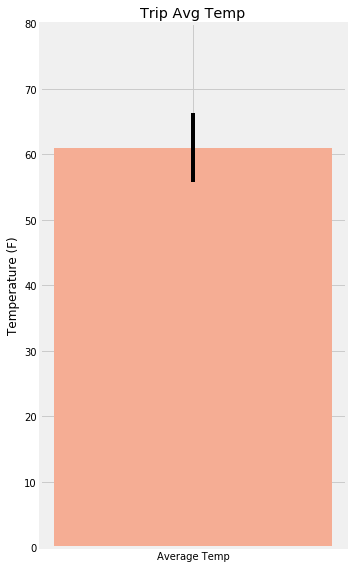

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,8))
plt.bar(x='Average Temp',height=t[0][0],yerr=t[0][2]-t[0][1],color=(246/256, 174/256, 149/256))
plt.ylim(0,80)
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.tight_layout()


In [19]:
#same_station = session.query(Measurement, Station).filter(Measurement.station == Station.station).limit(10).all()

sel = [Measurement.station,func.sum(Measurement.prcp),Measurement.date,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
same_station = session.query(*sel).filter(Measurement.station == Station.station).\
              filter(Measurement.date >= '2011-02-28').\
              filter(Measurement.date <= '2011-03-05').\
              filter(Measurement.prcp != None).\
              group_by(Measurement.station).\
              order_by(func.sum(Measurement.prcp).desc()).all()

for row in same_station:
    print(row)


('USC00518838', 2.33, '2011-03-01', 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
('USC00519281', 2.23, '2011-02-28', 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00519523', 2.19, '2011-02-28', 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00514830', 1.96, '2011-03-01', 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00516128', 1.45, '2011-02-28', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00513117', 1.44, '2011-02-28', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519397', 1.38, '2011-02-28', 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00511918', 0.63, '2011-02-28', 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
